# IMPORTS

In [77]:
%%capture
import sys
import re
import tensorflow as tf
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
 
# use this if you want to fine-tune EfficientNet
!pip install -U efficientnet
import efficientnet.tfkeras

# TPU / GPU DETECTION

In [78]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
 
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.
 
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.64.240.34:8470
INFO:tensorflow:Clearing out eager caches


Running on TPU  grpc://10.64.240.34:8470


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:ten

REPLICAS:  8


# DATA ACCESS
TPUs read data directly from Google Cloud Storage (GCS).

In [79]:
# GCS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_PATH"
GCS_PATH = 'gs://huynhdoo/prostate-cancer/mounting/'
!gsutil ls $GCS_PATH

gs://huynhdoo/prostate-cancer/mounting/128x16/
gs://huynhdoo/prostate-cancer/mounting/128x36/
gs://huynhdoo/prostate-cancer/mounting/256x36/
gs://huynhdoo/prostate-cancer/mounting/64x64/


# CONFIGURATION 

In [86]:
# The dataset can be availabe in multiple image sizes.
PATCH_SIZE = [128, 16]
IMAGE_SIZE = [PATCH_SIZE[0]*PATCH_SIZE[1], PATCH_SIZE[0]*PATCH_SIZE[1]]
TARGET_SIZE = [528, 528]
#EfficientNetB0 - (224, 224, 3) / EfficientNetB2 - (260, 260, 3) / EfficientNetB4 - (380, 380, 3) / EfficientNetB6 - (528, 528, 3)

BATCH_SIZE = 16 * strategy.num_replicas_in_sync # this is 8 on TPU v3-8, it is 1 on CPU and GPU
 
PANDA_DATASETS = { # available image sizes
    64: GCS_PATH + '64x64/tfrec-jpg-512x512/*.tfrec',
    128: GCS_PATH + 'tf-slide/tfrec-jpeg-512x512/*.tfrec',
    #128: GCS_PATH + '128x16/tfrec-jpg-512x512/*.tfrec',
    #128: GCS_PATH + '128x36/tfrec-jpg-768x768/*.tfrec',
    256: GCS_PATH + '256x36/tfrec-jpg-1536x1536/*.tfrec'
}
CLASSES = ['0', '1', '2', '3', '4', '5'] # do not change, maps to the labels in the data (folder names)
FRACTIONS = np.array([2892, 2666, 1343, 1242, 1249, 1224]).astype(np.float32)/10616
CLASSES_WEIGHTS = {0: 1.0, 
                   1: 1.0843881856540085, 
                   2: 2.153631284916201, 
                   3: 2.3269617706237424, 
                   4: 2.315315315315315, 
                   5: 2.362614913176711}
 
print('DATASETS:', PANDA_DATASETS[PATCH_SIZE[0]])
print('TFRECORDS:', len(tf.io.gfile.glob(PANDA_DATASETS[PATCH_SIZE[0]])))

DATASETS: gs://huynhdoo/prostate-cancer/mounting/tf-slide/tfrec-jpeg-512x512/*.tfrec
TFRECORDS: 42


# VISUALIZATIONS UTILITIES

data -> pixels, nothing of much interest for the machine learning practitioner in this section.

In [87]:
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels
 
def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)  # one-hot to class number
    correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct
 
def display_one_image(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_images_from_dataset(dataset, num):
    subplot=331
    plt.figure(figsize=(13,13))
    images, labels = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        if i >= num:
            break;
        title = CLASSES[np.argmax(labels[i], axis=-1)]
        subplot = display_one_image(image, title, subplot)
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()  
 
def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_image(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# DATASET

## Dataset utilities

In [88]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)
 
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "label": tf.io.FixedLenFeature([], tf.string),
        "class_num": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
 
    # Standardize image
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]    
    #image = tf.image.per_image_standardization(image) # standardize image with 0 mean and 1 deviation
    image = tf.image.resize(image, size = TARGET_SIZE) # standardize image size
    
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [6])
    return image, one_hot_class
 
def load_dataset(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
 
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
 
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset
    
def balance_dataset(dataset):
    get_label = lambda image, one_hot_class: tf.argmax(one_hot_class)
 
    resample_ds = dataset.apply(
        tf.data.experimental.rejection_resample(
            get_label, 
            target_dist=[1/len(CLASSES)]*len(CLASSES), 
            initial_dist=FRACTIONS)
        )
    dataset = resample_ds.map(lambda extra_label, features_and_label: features_and_label)
    return dataset
 
def data_augment(image, one_hot_class):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_saturation(image, 0, 2)
    #image = tf.image.random_contrast(image, 0, 2)
    #image = tf.image.random_brightness(image, 0.2)
    return image, one_hot_class
 
def get_training_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = balance_dataset(dataset)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.shuffle(2048)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset
 
def get_validation_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

## Dataset loading

In [89]:
GCS_PATTERN = PANDA_DATASETS[PATCH_SIZE[0]]
FILENAMES = tf.io.gfile.glob(GCS_PATTERN)
TEST_SPLIT = 0.01
FOLDS = 5
 
REMAINING_FILENAMES, TEST_FILENAMES = train_test_split(FILENAMES, test_size=TEST_SPLIT, random_state=512)
TRAINING_FILENAMES = []
VALIDATION_FILENAMES = []
TRAIN_STEPS = []
 
kfold = KFold(FOLDS, shuffle = True, random_state = 512)
for fold, (trn_ind, val_ind) in enumerate(kfold.split(REMAINING_FILENAMES)):
    TRAINING_FILENAMES.append(np.array(REMAINING_FILENAMES)[trn_ind])
    VALIDATION_FILENAMES.append(np.array(REMAINING_FILENAMES)[val_ind])
    TRAIN_STEPS.append(count_data_items(TRAINING_FILENAMES[fold]) // BATCH_SIZE)
 
training_dataset = []
validation_dataset = []
 
for fold in range(FOLDS):
    training_dataset.append(get_training_dataset(TRAINING_FILENAMES[fold]))
    validation_dataset.append(get_validation_dataset(VALIDATION_FILENAMES[fold]))
 
print("TOTAL IMAGES:", count_data_items(FILENAMES), "- FOLDS:", FOLDS)
print("TESTING IMAGES:", count_data_items(TEST_FILENAMES))
print("REMAINING IMAGES:", count_data_items(REMAINING_FILENAMES))
print("-"*30)
print("TRAINING IMAGES:", count_data_items(TRAINING_FILENAMES[0]), "- STEPS PER EPOCH:", TRAIN_STEPS[0])
print("VALIDATION IMAGES:", count_data_items(VALIDATION_FILENAMES[0]))
print("-"*30)

TOTAL IMAGES: 10516 - FOLDS: 5
TESTING IMAGES: 255
REMAINING IMAGES: 10261
------------------------------
TRAINING IMAGES: 7966 - STEPS PER EPOCH: 62
VALIDATION IMAGES: 2295
------------------------------


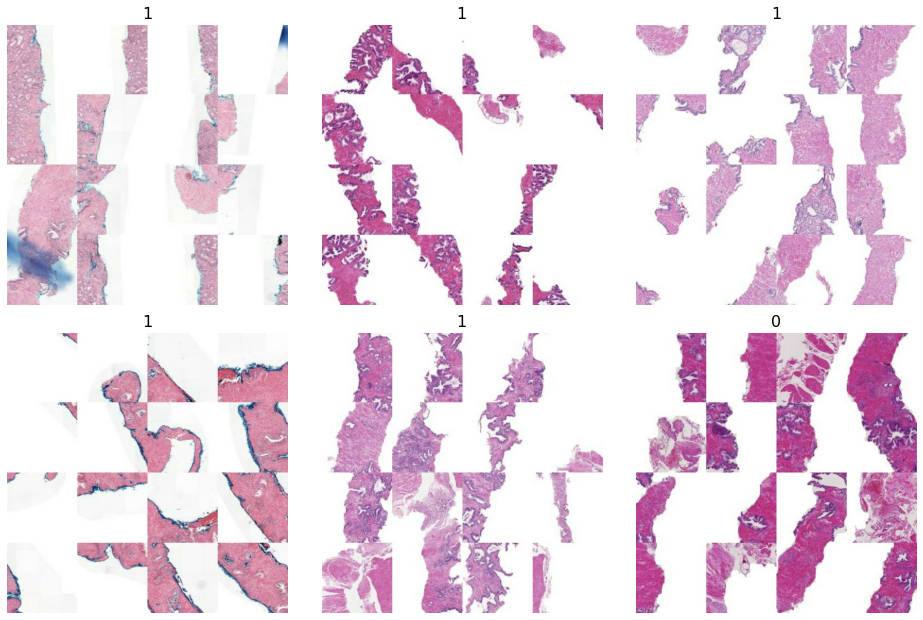

In [90]:
display_images_from_dataset(training_dataset[random.choice(range(FOLDS))], 6)

# MODEL

## Kappa Loss function

In [91]:
import tensorflow.keras.backend as K
 
# Metrics
def quadratic_kappa_coefficient(y_true, y_pred):
    n_classes = K.cast(y_pred.shape[-1], "float32")
    weights = K.arange(0, n_classes, dtype="float32") / (n_classes - 1)
    weights = (weights - K.expand_dims(weights, -1)) ** 2
 
    hist_true = K.sum(y_true, axis=0)
    hist_pred = K.sum(y_pred, axis=0)
 
    E = K.expand_dims(hist_true, axis=-1) * hist_pred
    E = E / K.sum(E, keepdims=False)
 
    O = K.transpose(K.transpose(y_true) @ y_pred)  # confusion matrix
    O = O / K.sum(O)
 
    num = weights * O
    den = weights * E
 
    QWK = (1 - K.sum(num) / K.sum(den))
    return QWK
 
# Loss
def quadratic_kappa_loss(scale=6.0):
    def _quadratic_kappa_loss(y_true, y_pred):
        QWK = quadratic_kappa_coefficient(y_true, y_pred)
        loss = -K.log(K.sigmoid(scale * QWK))
        return loss
 
    return _quadratic_kappa_loss

## Model definition

In [92]:
def create_model(trainable=True):
    with strategy.scope():
        #pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=[*TARGET_SIZE, 3], include_top=False)
        #pretrained_model = tf.keras.applications.Xception(weights='imagenet', input_shape=[*TARGET_SIZE, 3], include_top=False)
        #pretrained_model = tf.keras.applications.VGG16(weights='imagenet', input_shape=[*TARGET_SIZE, 3], include_top=False)
        #pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', input_shape=[*TARGET_SIZE, 3], include_top=False)
        #pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', input_shape=[*TARGET_SIZE, 3], include_top=False)
        
        # EfficientNet can be loaded through efficientnet.tfkeras library (https://github.com/qubvel/efficientnet)
        #pretrained_model = efficientnet.tfkeras.EfficientNetB0(weights='imagenet', input_shape=[*TARGET_SIZE, 3], include_top=False)
        #pretrained_model = efficientnet.tfkeras.EfficientNetB2(weights='imagenet', input_shape=[*TARGET_SIZE, 3], include_top=False)
        #pretrained_model = efficientnet.tfkeras.EfficientNetB4(weights='imagenet', input_shape=[*TARGET_SIZE, 3], include_top=False)
        pretrained_model = efficientnet.tfkeras.EfficientNetB6(weights='imagenet', input_shape=[*TARGET_SIZE, 3], include_top=False)
        
        pretrained_model.trainable = trainable
 
        model = tf.keras.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Flatten(), # EfficientNet
            tf.keras.layers.Dropout(0.2), # EfficientNet
            #tf.keras.layers.Dense(128, activation='relu'), # EfficientNet
            tf.keras.layers.Dense(len(CLASSES), activation='softmax')
        ])
 
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        #loss = 'categorical_crossentropy',
        #metrics='categorical_accuracy'
        loss = quadratic_kappa_loss(scale=len(CLASSES)),
        metrics=[quadratic_kappa_coefficient]
    )
    return model

In [ ]:
# Show model
# del model
model = create_model(False)
model.summary()

16809984/16804768 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 4,057,250
Trainable params: 7,686
Non-trainable params: 4,049,564
_________________________________________________________________


## Load model

In [ ]:
# Load previous model
#with strategy.scope():
  #model = tf.keras.models.load_model('model.h5')
#model.summary()

# TRAINING

## Learning rate scheduler

Learning rate schedule: 3e-05 to 0.00024 to 3.92e-05


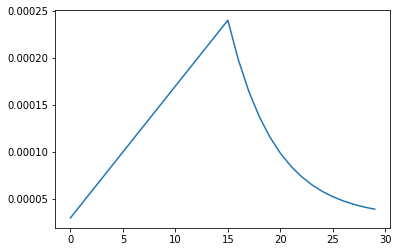

In [101]:
# Learning rate scheduler for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.
EPOCHS = 30
LR_START = 3e-5
LR_MAX = LR_START * 1 * strategy.num_replicas_in_sync
LR_MIN = LR_START
LR_RAMPUP_EPOCHS = 15
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = 0.8
 
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
 
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Training function

In [99]:
def training(folds, weigths=None):
    histories = []
    models = []
 
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
 
    for fold in range(folds):
        print('Release TPU memory...')
        tf.tpu.experimental.initialize_tpu_system(tpu) # Release TPU memory
 
        print('Creating model {}/{}...'.format(fold+1, folds))
        model = create_model(trainable=True)
 
        if weigths:
            print('Loading weights {}...'.format(weigths))
            model.load_weights(weigths)
 
        checkpoint_name = f'model_fold_{fold + 1}' + '.h5'
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, 
                                                            save_best_only = True, 
                                                            save_weights_only = True)
        
        print('Training model {}/{}...'.format(fold+1, folds))        
        history = model.fit(
            training_dataset[fold], 
            steps_per_epoch = TRAIN_STEPS[fold],
            epochs = EPOCHS,
            class_weight=CLASSES_WEIGHTS,
            callbacks = [early_stopping, model_checkpoint, lr_callback],
            validation_data = validation_dataset[fold]
        )
        model_accuracy = history.history["val_categorical_accuracy"][-5:]
        model_accuracy = history.history["val_quadratic_kappa_coefficient"][-5:]
        print("Model accuracy MEAN-5: ", np.mean(model_accuracy))
 
        print('Saving best model {}/{}'.format(fold+1, folds)) 
        model.load_weights(checkpoint_name)
        models.append(model)
        histories.append(history)
 
    return models, histories

## One step training

In [97]:
# Save model
# !gsutil cp EfficientNetB6_ckpt.h5 gs://huynhdoo/prostate-cancer/model/

# Retrieve model
# !gsutil cp gs://huynhdoo/prostate-cancer/model/EfficientNetB6_ckpt.h5 .

In [ ]:
# One step training
# model, history = training(1, 'EfficientNetB6_ckpt.h5')
model, history = training(1)

INFO:tensorflow:Initializing the TPU system: grpc://10.64.240.34:8470
INFO:tensorflow:Clearing out eager caches


Release TPU memory...


INFO:tensorflow:Finished initializing TPU system.


Creating model 1/1...
Training model 1/1...

Epoch 00001: LearningRateScheduler reducing learning rate to 3e-05.
Epoch 1/30
62/62 [==============================] - 111s 2s/step - loss: 0.7180 - quadratic_kappa_coefficient: 0.1584 - val_loss: 0.4591 - val_quadratic_kappa_coefficient: 0.0944 - lr: 3.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 4.4e-05.
Epoch 2/30
62/62 [==============================] - 81s 1s/step - loss: 0.2169 - quadratic_kappa_coefficient: 0.4064 - val_loss: 0.2576 - val_quadratic_kappa_coefficient: 0.2202 - lr: 4.4000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 5.8e-05.
Epoch 3/30
62/62 [==============================] - 81s 1s/step - loss: 0.1303 - quadratic_kappa_coefficient: 0.4973 - val_loss: 0.1665 - val_quadratic_kappa_coefficient: 0.3126 - lr: 5.8000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 7.2e-05.
Epoch 4/30
62/62 [==============================] - 81s 1s/step - loss: 0.1060 - quadrat

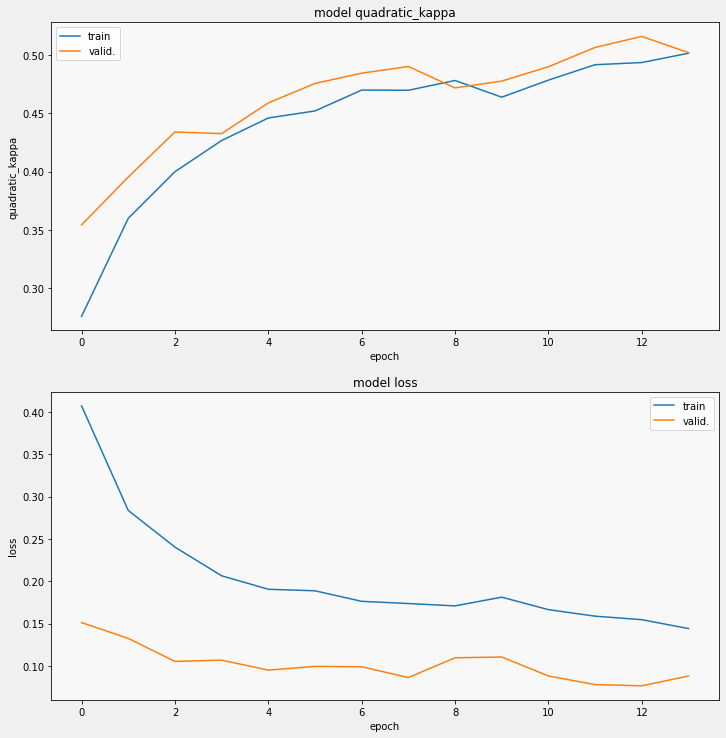

In [ ]:
# Displaying curves
display_training_curves(history[0].history['quadratic_kappa_coefficient'][1:], history[0].history['val_quadratic_kappa_coefficient'][1:], 'quadratic_kappa', 211)
display_training_curves(history[0].history['loss'][1:], history[0].history['val_loss'][1:], 'loss', 212)

## Fine-tuning

In [ ]:
model, history = training(False)

## Cross validation training

In [ ]:
# Cross validation training
models, histories = training(FOLDS)

INFO:tensorflow:Initializing the TPU system: grpc://10.32.238.58:8470
INFO:tensorflow:Clearing out eager caches


Release TPU memory...


INFO:tensorflow:Finished initializing TPU system.


Creating model 1/5...
Training model 1/5...

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/30
125/125 [==============================] - 110s 878ms/step - loss: 0.4656 - quadratic_kappa_coefficient: 0.2736 - val_loss: 0.1853 - val_quadratic_kappa_coefficient: 0.3388 - lr: 5.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 1.65e-05.
Epoch 2/30
125/125 [==============================] - 99s 792ms/step - loss: 0.1760 - quadratic_kappa_coefficient: 0.4530 - val_loss: 0.0818 - val_quadratic_kappa_coefficient: 0.4925 - lr: 1.6500e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2.8000000000000003e-05.
Epoch 3/30
125/125 [==============================] - 96s 768ms/step - loss: 0.1165 - quadratic_kappa_coefficient: 0.5299 - val_loss: 0.0549 - val_quadratic_kappa_coefficient: 0.5651 - lr: 2.8000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 3.9500000000000005e-05.
Epoch 4/30
125/125 [======================

INFO:tensorflow:Initializing the TPU system: grpc://10.32.238.58:8470
INFO:tensorflow:Clearing out eager caches


Release TPU memory...


INFO:tensorflow:Finished initializing TPU system.


Creating model 2/5...
Training model 2/5...

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/30
129/129 [==============================] - 114s 883ms/step - loss: 0.4626 - quadratic_kappa_coefficient: 0.2784 - val_loss: 0.1789 - val_quadratic_kappa_coefficient: 0.3259 - lr: 5.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 1.65e-05.
Epoch 2/30
129/129 [==============================] - 103s 802ms/step - loss: 0.1766 - quadratic_kappa_coefficient: 0.4500 - val_loss: 0.0865 - val_quadratic_kappa_coefficient: 0.4879 - lr: 1.6500e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2.8000000000000003e-05.
Epoch 3/30
  4/129 [..............................] - ETA: 59s - loss: 0.1935 - quadratic_kappa_coefficient: 0.4360

In [ ]:
# Displaying curves
for fold in range(FOLDS):
    history = histories[fold]
    print('Model ', fold+1)
    display_training_curves(history.history['quadratic_kappa_coefficient'][1:], history.history['val_quadratic_kappa_coefficient'][1:], 'quadratic_kappa', 211)
    display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

# GOOGLE CLOUD CREDENTIALS
You would need this if you were accessing private GCS buckets. Uncomment if you want to re-use this notebook to write data to you own private bucket.

In [84]:
if 'google.colab' in sys.modules:
   from google.colab import auth
   auth.authenticate_user()

# SAVE MODEL

In [ ]:
model.save('EfficientNetB0_768px.h5')

In [ ]:
!gsutil cp EfficientNetB0_768px.h5 gs://huynhdoo/prostate-cancer/model/
#!gsutil cp model_fold_2.h5 gs://huynhdoo/prostate-cancer/model/EfficientB0_fold_2.h5
#!gsutil cp model_fold_3.h5 gs://huynhdoo/prostate-cancer/model/EfficientB0_fold_3.h5

Copying file://EfficientNetB0_768px.h5 [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/97.5 MiB.                                     


# RELOAD MODEL

In [ ]:
!gsutil cp gs://huynhdoo/prostate-cancer/model/EfficientNetB0_768px.h5 .

Copying gs://huynhdoo/prostate-cancer/model/EfficientNetB0_768px.h5...
- [1 files][ 97.5 MiB/ 97.5 MiB]                                                
Operation completed over 1 objects/97.5 MiB.                                     


In [ ]:
reload_model = tf.keras.models.load_model('EfficientNetB0_768px.h5', compile=False)

# PREDICTIONS

In [ ]:
def predict(models, folds, dataset):
    # get the mean probability of the folds models
    probabilities = np.average([models[i].predict(dataset) for i in range(folds)], axis = 0)
    predictions = np.argmax(probabilities, axis=-1)
    return predictions

test_dataset = load_dataset(TEST_FILENAMES, ordered=True)

## One step prediction

In [ ]:
from sklearn.metrics import cohen_kappa_score

# Make predictions on one step training
y_preds = predict([reload_model], 1, test_dataset.batch(BATCH_SIZE))
y_truth = [np.argmax(label.numpy()) for image, label in test_dataset]
print(list(y_preds)[:10])
print(y_truth[:10])
# print('Mean accuracy:', round(np.count_nonzero(y_preds == np.array(y_truth))/len(y_truth),2))
print('Kappa score:', cohen_kappa_score(y_truth, y_preds, weights = 'quadratic'))

[4, 3, 0, 1, 4, 1, 2, 4, 4, 1]
[4, 0, 0, 1, 3, 1, 2, 5, 0, 0]
Kappa score: 0.4883761939750184


## Cross validation prediction 

In [ ]:
# Cross validation prediction on test dataset
y_preds = predict(models, test_dataset.batch(BATCH_SIZE))
y_truth = [np.argmax(label.numpy()) for image, label in test_dataset]

In [ ]:
print(list(y_preds)[:30])
print(y_truth[:30])
print('Mean accuracy:', round(np.count_nonzero(y_preds == np.array(y_truth))/len(y_truth),2))

[0, 0, 4, 1, 0, 5, 0, 0, 2, 0, 1, 0, 2, 4, 1, 0, 1, 0, 1, 4, 0, 2, 0, 0, 5, 0, 2, 0, 2, 0]
[5, 1, 4, 1, 2, 5, 0, 0, 2, 4, 2, 0, 2, 4, 1, 1, 1, 0, 2, 3, 0, 2, 0, 4, 5, 1, 1, 0, 1, 0]


0.5843137254901961

In [ ]:
# a couple of images to test predictions too
test_dataset = get_validation_dataset(TEST_FILENAMES)
some_slides, some_labels = dataset_to_numpy_util(test_dataset, 160)

# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(8*20)
some_slides, some_labels = (some_slides[permutation], some_labels[permutation])

predictions = model.predict(some_slides, batch_size=BATCH_SIZE)
evaluations = model.evaluate(some_slides, some_labels, batch_size=BATCH_SIZE)
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

display_9_images_with_predictions(some_slides, predictions, some_labels)

# LICENSE



---

ORIGINAL<br>
author: Martin Gorner<br>
twitter: @martin_gorner

FORK<br>
author: Do Huynh<br>
git: huynhdoo

---


Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
